### 在 github clone 專案：[連結](https://github.com/bill0812/Detection-Tutorial)

In [ ]:
!nvidia-smi

In [ ]:
%%bash

git clone https://github.com/bill0812/Detection-Tutorial.git
mv Detection-Tutorial/PennFudanPed/ .
mv Detection-Tutorial/detection_tutorial/ .

### 引入相關需要的套件

In [ ]:
!pipenv install matplotlib

In [1]:
# import basic packages
import cv2, sys, torch, glob, os, functools, time
from tqdm import tqdm
import numpy as np
import os.path as osp
from pathlib import Path ,PurePath
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from pprint import PrettyPrinter

# import pytorch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms as T

# import model
from detection_tutorial.Model.Detector.single_stage_detector import single_stage_detector as ssd_detector

# import checkpointer
from detection_tutorial.Datasets.augmentation import Augmentation
from detection_tutorial.Utils.checkpoint import checkpointer
from detection_tutorial.Datasets.custom import CustomDataset
from detection_tutorial.Utils.detect import Detection
from detection_tutorial.Utils.loss import MultiBoxLoss
from detection_tutorial.Apis.config import *

# import box_utils
from detection_tutorial.Utils.box_utils import *

pp = PrettyPrinter()

### 首先先取得 Configs 裡面的所有變數，包括模型、訓練參數與測試參數

In [2]:
# import datasets / config, and also train and test from apis
from detection_tutorial.Apis.config import get_config_dict, training_config_declare
from detection_tutorial.Apis.train import train as TRAIN
from detection_tutorial.Apis.test import test as TEST

# the config file that we'll use later
ssd_config = "detection_tutorial/Config/ssd_config.py"

# retrieve configs 
model_config, training_config, testing_config, dataset_config = get_config_dict(ssd_config)

| Loading All Configs in /home/bill/Desktop/graduation_VIPL/bayesian_bigscale/research_workshop/detection_tutorial/detection_tutorial/Config/ssd_config.py...


### 利用上述引進的參數來宣告訓練時所需的變數

In [3]:
# declare device
print("| Loading Device ...")
if training_config["device"]["GPU"] >= 1 :
    if torch.cuda.is_available() :
        device = torch.device("cuda")
    else :
        device = torch.device("cpu")
        print("| Only Can Use CPU !!!")
elif training_config["device"]["GPU"] == 0 :
    device = torch.device("cpu")
else :
    raise TypeError("Should be either 'GPU' or 'CPU' !!!")
    
print("| Loading Training Configs ...")
epoch = training_config["epoch"]
batch_size = training_config["batch_size"]
number_workers = training_config["number_workers"]
validation = training_config["validation"]


print("| Loading Optimizer, Loss Object, and some others ...")
# declare optimizers
lr_rate = training_config["learning_rate"]
weight_decay = training_config["weight_decay"]
gamma = training_config["gamma"]
gradient_clip = training_config["gradient_clip"]
optimizer_kind = training_config["optimizer"]
learning_steps = training_config["lr_steps"]
momentum = training_config["momentum"]
detection_endecode_variance = model_config["prior_box"]["variance"]
    
# define model
model = ssd_detector(model_config, training_config, "train", device) 

# declare detection object for detection job
detection = Detection(training_config["validation"]["config"], model.anchor_head.prior_box, model.anchor_head.num_classes, model.device, detection_endecode_variance)
    
# declare loss object for computing loss job
multiboxloss = MultiBoxLoss(model_config["loss_function"], model.anchor_head.center_variance, \
    model.anchor_head.size_variance, model.anchor_head.prior_box, model.anchor_head.num_classes, model.device)

# Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
biases = list()
not_biases = list()
for param_name, param in model.named_parameters():
    if param.requires_grad:
        if param_name.endswith('.bias'):
            biases.append(param)
        else:
            not_biases.append(param)
optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr_rate}, {'params': not_biases}],
									lr=lr_rate, momentum=momentum, weight_decay=weight_decay)


model = model.to(device)
detection = detection.to(device)
multiboxloss = multiboxloss.to(device)

checkpoint = training_config["checkpoint"]
train_logger = checkpointer(model, checkpoint)

| Loading Device ...
| Loading Training Configs ...
| Loading Optimizer, Loss Object, and some others ...


### 接者定義資料及以及 Collator

In [4]:
# import basic packages
import cv2, sys, torch, glob, os
from tqdm import tqdm
import numpy as np
import os.path as osp
from PIL import Image
from pathlib import Path ,PurePath

# import pytorch packages
from torch.utils.data.dataset import Dataset

class CustomDataset(Dataset):
	"""
	A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
	"""

	# basic setup
	def __init__(self, current_mode, data_root, label_file, transform):
		
		self.label_map, self.label_color = self.map_labels(label_file)
		self.range = list(self.label_map.keys())[:-1]
		self.category = [0 for i in self.range]
		self.data_root = data_root
		self.count = 1 
		self.transform = transform
		self.mode = current_mode
		self.result = {}
		self.images = []

		# use os.path get directory name
		dataset_name = os.path.basename(os.path.normpath(self.data_root))
		data_kind, check_folder = os.path.splitext(dataset_name)

		# load data
		if data_kind == "PennFudanPed" and check_folder == "":
			self.load_PennFudanPed()
		elif data_kind == "Xview" and check_folder == ".csv":
			self.load_Xivew()
		else :
			raise TypeError("| DataSet Name Should Be 'PennFudanPed' or 'Xview' !!")

	def collate_fn(self, batch, mode):
		"""
		Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).

		This describes how to combine these tensors of different sizes. We use lists.

		Note: this need not be defined in this Class, can be standalone.

		:param batch: an iterable of N sets from __getitem__()
		:return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
		"""

		images = list()
		images_original = list()
		boxes = list()
		labels = list()
		difficulties = list()

		if mode == "train" or mode == "validation" :

			for b in batch:
				images.append(b[0])
				boxes.append(b[1])
				labels.append(b[2])
				difficulties.append(b[3])
			
			images = torch.stack(images, dim=0)

			return images, boxes, labels, difficulties  # tensor (N, 3, 300, 300), 3 lists of N tensors each
		else :
			for b in batch:

				images.append(b[0])
				images_original.append(b[1])

			images = torch.stack(images, dim=0)
			images_original = torch.stack(images_original, dim=0)

			return images, images_original  # tensor (N, 3, 300, 300), 3 lists of N tensors each

	def map_labels(self, label_file):
	
		label_map = {}
		label_color = {}
		labels = open(label_file, 'r')
		for line in labels:
			ids = line.split(',')
			label_map[int(ids[0])] = ids[1].split('\n')[0]
			label_color[int(ids[0])] = ids[2].split('\n')[0]
		
		return label_map, label_color

	# load image name and ground truth
	def load_PennFudanPed(self) :

		# load all image files, sorting them to
		# ensure that they are aligned
		self.image_path = list(sorted(os.listdir(os.path.join(self.data_root, "PNGImages"))))
		self.mask_path = list(sorted(os.listdir(os.path.join(self.data_root, "PedMasks"))))

		assert len(self.image_path) == len(self.mask_path)

		for index in range(len(self.image_path)) :

			# get name
			img_name = os.path.join(self.data_root, "PNGImages", self.image_path[index])

			# get number object
			mask_name = os.path.join(self.data_root, "PedMasks", self.mask_path[index])
			mask = Image.open(mask_name)
			mask = np.array(mask)
			# instances are encoded as different colors
			obj_ids = np.unique(mask)
			# first id is the background, so remove it
			obj_ids = obj_ids[1:]
			# split the color-encoded mask into a set
			# of binary masks
			masks = mask == obj_ids[:, None, None]

			# get bounding box coordinates for each mask
			num_objs = len(obj_ids)
			boxes = []

			# get positione / label / difficulties
			for i in range(num_objs):

				if img_name not in self.result :
					self.result[img_name] = []

				pos = np.where(masks[i])
				xmin = np.min(pos[1])
				xmax = np.max(pos[1])
				ymin = np.min(pos[0])
				ymax = np.max(pos[0])
				self.result[img_name].append(np.array([xmin, ymin, xmax, ymax, 1, 0]))

		self.images = list(self.result.keys())

	def load_Xivew(self,) :

		# retrieve data from ground truth
		with open(filename,"r") as file_detail :
			for line, row in enumerate(file_detail) :
			
				# retrieve xmin, ymin, xmax, ymax, class_name
				img_name, xmin, ymin, xmax, ymax, class_name = row.split(",")
				xmin = int(float(xmin))
				ymin = int(float(ymin))
				xmax = int(float(xmax))
				ymax = int(float(ymax))
				class_name = int(float(class_name.split("\n")[0]))

				if img_name not in self.result :
					self.result[img_name] = []

				if (xmin, ymin, xmax, ymax, class_name) == ('', '', '', '', '') :
					continue

				self.result[img_name].append(np.array([xmin, ymin, xmax, ymax, class_name, 0]))

		self.images = list(self.result.keys())

	def load_test_image(self) :

		all_files = glob.glob(self.current_dir)
		all_files.sort()

		# retrieve data from testing data
		for each_test_image in tqdm(all_files) :
			
			self.images.append(each_test_image)
		
	# load image
	def load_image(self, index) :
		
		# img = cv2.imread(self.images[index])		
		# height, width, channels = img.shape
		image = Image.open(self.images[index]).convert('RGB')

		return image

	# load ground truth
	def load_ground_truth(self, index) :

		# get ground truth
		groundtruth = np.asarray(self.result[self.images[index]])
		boxes = groundtruth[:,0:4]
		classes = groundtruth[:,4:5]
		difficulties = groundtruth[:,5:6]

		# Do some transformation of boxes
		boxes = np.array(boxes).astype(np.float64)

		return boxes, classes, difficulties

	def __getitem__(self, index):

		# declare some variables
		img_class = []
	
		img = self.load_image(index)

		if self.mode == "train" or self.mode == "validation":

			boxes, classes, difficulties = self.load_ground_truth(index)

			# how many bounding boxes, then you'll have that amount of classes
			assert boxes.shape[0] == classes.shape[0]

			# transfer to numpy first
			bounding_box = torch.from_numpy(boxes)
			img_class = torch.from_numpy(classes)
			difficulties = torch.from_numpy(difficulties)

			# set type
			bounding_box = bounding_box.type(torch.float32)
			img_class = img_class.type(torch.float32).squeeze(1)
			difficulties = difficulties.type(torch.uint8).squeeze(1)
			
			img, boxes, labels, difficulties = self.transform(img, bounding_box, img_class, difficulties)

			return img, boxes, labels, difficulties
		else :
			
			img_original = img.resize((300, 300),Image.ANTIALIAS)
			img_original = np.asarray(img_original)
			img_original = torch.from_numpy(img_original)
			bounding_box = torch.from_numpy(np.array([[0,0,0,0]]))
			img_class = torch.from_numpy(np.array([0]))
			difficulties = torch.from_numpy(np.array([0]))

			bounding_box = bounding_box.type(torch.float32)
			img_class = img_class.type(torch.float32)
			difficulties = difficulties.type(torch.uint8)
			new_img, boxes, labels, difficulties = self.transform(img, bounding_box, img_class, difficulties)

			return new_img, img_original
	def __len__(self):
		return len(self.images)

### 定義 Dataloader，包括訓練、驗證以及測試

In [5]:
print("| Loading Dataset ... ")
map_overlap = 0
current_dataset_name = dataset_config["dataset_name"]
label_file = "detection_tutorial/Datasets/label.txt"
val_data_file = "PennFudanPed"
train_data_file = "PennFudanPed"
augmentation_config = dataset_config["dataloader"]["transformation"]

# training data
# create dataset
augmentation_train = Augmentation(augmentation_config, "TRAIN")
dataset_train = CustomDataset("train", train_data_file, label_file, augmentation_train)
data_collater_train = functools.partial(dataset_train.collate_fn, mode="train")
# make a dataset
dataloader_train = DataLoader(dataset_train, batch_size, num_workers=number_workers, shuffle=True, \
    collate_fn=data_collater_train, pin_memory=True)

if training_config["validation"]["status"] :

    map_overlap = training_config["validation"]["mAP_overlap"]
    
    # validation data
    # create dataset
    augmentation_val = Augmentation(augmentation_config, "TRAIN")
    dataset_val = CustomDataset("validation", val_data_file, label_file, augmentation_val)
    data_collater_val = functools.partial(dataset_val.collate_fn, mode="validation")
    # make a dataset
    dataloader_val = DataLoader(dataset_val, batch_size, num_workers=number_workers, shuffle=True, \
        collate_fn=data_collater_val, pin_memory=True)
else :
    dataloader_val = None
    
# combine all data_loader
data_loader = {
    "train" : dataloader_train,
    "validation" : dataloader_val,
    "label_file" : label_file
}

| Loading Dataset ... 


### 顯示餵進去模型的圖片

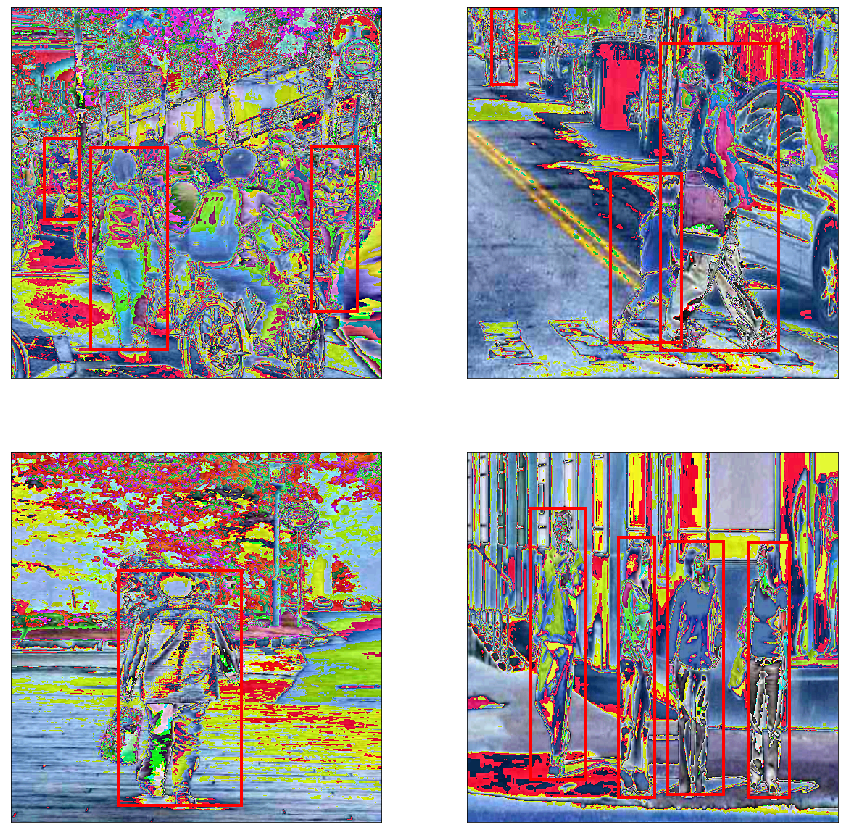

In [6]:
# helper function to un-normalize and display an image
def imshow(img):
    
    # Uncomment if normalizing the data
    img = img * 255
    img = np.transpose(img, (1, 2, 0)).astype(np.uint8)
    plt.imshow(img)  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(dataloader_train)
images, boxes, labels, _ = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15, 15))

# display 20 images
for idx in np.arange(4):
    
    ax = fig.add_subplot(2, 4/2, idx+1, xticks=[], yticks=[])
    
    for each_box_id in range(len(boxes[idx])) :
        this_each_box = boxes[idx][each_box_id]
        this_label = labels[idx][each_box_id].item()
        xmin = int(this_each_box[0].item()* 512)
        ymin = int(this_each_box[1].item() * 512)
        width = int((this_each_box[2].item()- this_each_box[0].item()) * 512)
        height = int((this_each_box[3].item() - this_each_box[1].item()) * 512)
        rect = patches.Rectangle((xmin,ymin),width,height,linewidth=3,edgecolor="r",facecolor='none')
        
        # Add the patch to the Axes
        ax.add_patch(rect)
    imshow(images[idx].numpy())

### 再來是定義我們的 SSD 模型中優化器所需的 Function

In [ ]:
# define some tools for optimizers
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

    return optimizer

# adjust learning rate
def adjust_learning_rate(optimizer, gamma, step, lr_rate):
    """Sets the learning rate to the initial LR decayed by 10 at every
        specified step
    # Adapted from PyTorch Imagenet example:
    # https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    lr = lr_rate * (gamma ** (step))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [ ]:
def clip_gradient(optimizer, grad_clip):
	"""
	Clips gradients computed during backpropagation to avoid explosion of gradients.

	:param optimizer: optimizer with the gradients to be clipped
	:param grad_clip: clip value
	"""
	for group in optimizer.param_groups:
		for param in group['params']:
			if param.grad is not None:
				param.grad.data.clamp_(-grad_clip, grad_clip)

# adjust learning rate
def adjust_learning_rate(optimizer, scale):

	"""Sets the learning rate to the initial LR decayed by 10 at every
		specified step
	# Adapted from PyTorch Imagenet example:
	# https://github.com/pytorch/examples/blob/master/imagenet/main.py
	"""
	for param_group in optimizer.param_groups:
		param_group['lr'] = param_group['lr'] * scale

	print("| DECAYING learning rate.\n The new LR is %f\n" % (optimizer.param_groups[1]['lr'],))


	return optimizer

### 定義 Train Function

In [ ]:
# define training
def train(dataloader, optimizer, model, train_logger,\
	 gradient_clip, each_epoch, final_epoch, multiboxloss, device) :
    
    # train mode
	model.train()

	# Batches
	for each_iter, (images, ground_truth_boxes, ground_truth_labels, _) in enumerate(dataloader) :

		# if each_iter == 2 :
		# 	 break

		# record beginning time
		start_time = time.time()

		# Move to default device
		images = images.to(device)  # (batch_size (N), 3, 300, 300)
		ground_truth_boxes = [b.to(device) for b in ground_truth_boxes]
		ground_truth_labels = [l.to(device) for l in ground_truth_labels]
		
		# Forward prop.
		predicted_boxes, predicted_scores = model(images)
		
		# 因為計算 loss，在論文提到：
		# we regress to offsets for the center (cx; cy) of the default bounding box (d)
		# and for its width (w) and height (h).
		# 因此在計算 loss 時，會先針對真實資料跟我們所定義的 prior box 找出 offset
		# 而我們要訓練的就是這個 offset，比直接訓練位置來好
		confidence_loss,  location_loss = multiboxloss(predicted_boxes, predicted_scores,\
				ground_truth_boxes, ground_truth_labels)
		total_loss = confidence_loss + location_loss

		# Backward prop.
		optimizer.zero_grad()
		total_loss.backward()

		# Clip gradients, if necessary
		if gradient_clip :
			clip_gradient(optimizer, True)

		# Update model
		optimizer.step()

		# update variables
		train_logger.update(time.time() - start_time, "time_train")
		train_logger.update(confidence_loss, "conf_train", batch_size=images.size(0))
		train_logger.update(location_loss, "loc_train", batch_size=images.size(0))

		print('| Training Epoch: [%d / %d][%d / %d]  /  '
				  'Data Time %.3f \n'
				  '| Confidence Loss %.4f /  '
				  'Coordinates Loss %.4f /  '
				  'Total Loss %.4f '
				  '\n===================================================================\n' %(each_epoch+1, final_epoch, each_iter, len(dataloader),\
										train_logger.time_train, train_logger.val_loss_conf_train, train_logger.val_loss_loc_train, \
										train_logger.val_loss_conf_train + train_logger.val_loss_loc_train), end="")

	return model, optimizer, multiboxloss

### 定義 Validation Function

In [ ]:
def val(dataloader, model, optimizer, best_loss, label_file, multiboxloss, \
	detection, device, train_logger, each_epoch, final_epoch, validation_iou_max) :
    
    # set for caculating mAP
	det_boxes = list()
	det_labels = list()
	det_scores = list()
	true_boxes = list()
	true_labels = list()
	true_difficulties = list()
	validation_loss = 0
	
	# eval mode
	model.eval()
	
	# with no gradient
	with torch.no_grad() :

		# Batches
		for each_iter, (images, ground_truth_boxes, ground_truth_labels, difficulties) in enumerate(dataloader) :

			# record beginning time
			start_time = time.time()

			# Move to default device
			images = images.to(device)  # (N, 3, 300, 300)
			ground_truth_boxes = [b.to(device) for b in ground_truth_boxes]
			ground_truth_labels = [l.to(device) for l in ground_truth_labels]
			difficulties = [d.to(device) for d in difficulties]

			# Forward prop.
			predicted_boxes, predicted_scores = model(images)

			# 因為計算 loss，在論文提到：
			# we regress to offsets for the center (cx; cy) of the default bounding box (d)
			# and for its width (w) and height (h).
			# 因此在計算 loss 時，會先針對真實資料跟我們所定義的 prior box 找出 offset
			# 而我們要訓練的就是這個 offset，比直接訓練位置來好
			confidence_loss,  location_loss = multiboxloss(predicted_boxes, predicted_scores,\
				ground_truth_boxes, ground_truth_labels)
			total_loss = confidence_loss + location_loss

			# update variables
			train_logger.update(time.time() - start_time, "time_val")
			train_logger.update(confidence_loss, "conf_val", batch_size=images.size(0))
			train_logger.update(location_loss, "loc_val", batch_size=images.size(0))

			# detection result
			all_images_boxes, all_images_labels, all_images_scores = detection(predicted_boxes, predicted_scores)

			det_boxes.extend(all_images_boxes)
			det_labels.extend(all_images_labels)
			det_scores.extend(all_images_scores)
			true_boxes.extend(ground_truth_boxes)
			true_labels.extend(ground_truth_labels)
			true_difficulties.extend(difficulties)

			print('| Validation Epoch: [%d / %d][%d / %d]  /  '
					'Data Time %.3f \n'
					'| Confidence Loss %.4f /  '
					'Coordinates Loss %.4f /  '
					'Total Loss %.4f '
					'\n===================================================================\n' %(each_epoch+1, final_epoch, each_iter+1, len(dataloader),\
											train_logger.time_val, train_logger.val_loss_conf_val, train_logger.val_loss_loc_val, \
											train_logger.val_loss_conf_val + train_logger.val_loss_loc_val), end="")
			
			txt_content = '| Validation Epoch: [{} / {}][{} / {}]  /  Data Time {} \n| Confidence Loss {} / Coordinates Loss {} /  Total Loss {} \n===================================================================\n'.format(each_epoch+1, final_epoch, each_iter+1, len(dataloader),\
											train_logger.time_val, train_logger.val_loss_conf_val, train_logger.val_loss_loc_val, \
											train_logger.val_loss_conf_val + train_logger.val_loss_loc_val)

			train_logger.update_log(txt_content)
			validation_loss += total_loss.item()

			del all_images_boxes, all_images_labels, all_images_scores
			del ground_truth_boxes, ground_truth_labels, difficulties
			del predicted_boxes, predicted_scores
			del total_loss, confidence_loss, location_loss
		
	# 檢查要不要 update model
	if validation_loss < best_loss : 
		best_loss = validation_loss
		update_status = True
	else :
		update_status = False
	
	train_logger.update_model(model, optimizer, best_loss, validation_loss, update_status, each_epoch)

	torch.cuda.empty_cache()

	# Calculate mAP
	APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties, label_file, device)

	# Print AP for each class
	print("==============================")
	print("APs : =>")
	pp.pprint(APs)
	print("\nMean Average Precision : => {:.3f}".format(mAP))
	print("==============================")

	del APs, mAP
	torch.cuda.empty_cache()

	return model, optimizer, best_loss, multiboxloss

### 開始訓練吧！！

In [ ]:
best_loss = 1000000

# declare step index
step_index = 0
# Start Training
print("| Start Training ... ")

# 可以自己調這個參數
epoch = 100
for each_epoch in range(0, epoch) :

    # if each_epoch in lr_steps:
    # 	print("| Now We Update Learning Rate...")
    # 	step_index += 1
    # 	optimizer = adjust_learning_rate(optimizer, 0.1)

    print("| Training Iter ... ")
    model, optimizer, multiboxloss = train(data_loader["train"], optimizer, model, train_logger,\
         gradient_clip, each_epoch, epoch, multiboxloss, device)
    print("| Finish Training Iter ... ")

    if validation["status"] :

        # validation iter
        if (each_epoch+1) % validation["number_epoch"] == 0 :

            print("| Validation Iter ... ")
            model, optimizer, best_loss, multiboxloss = val(data_loader["validation"], model, optimizer, best_loss,\
                 data_loader["label_file"], multiboxloss, detection, device, train_logger, each_epoch, epoch, map_overlap)
            print("| Finish Validation Iter... ")
        else :

            print("| Skip Validation ... ")
    else :
        print("| Skip Validation ... ")

###   創建一個 Test Loader，原圖進去

In [ ]:
# retrieve testing data
augmentation_test = Augmentation(augmentation_config, "TEST")
# create dataset
dataset_test = CustomDataset("test", "PennFudanPed", label_file, augmentation_test)
data_collater_test = functools.partial(dataset_test.collate_fn, mode="test")

# make a dataset
dataloader_test = DataLoader(dataset_test, batch_size, num_workers=number_workers, shuffle=True, \
    collate_fn=data_collater_test, pin_memory=True)

### 利用剛剛訓練的 Model 來偵測物件！

In [ ]:
# result
result_boxes = []
result_score = []

# put the model in evaluation mode
model.eval()

model = model.to(device)

image_iter_choice = []
all_boxes = []
all_labels = []
all_image = []

# predict result
with torch.no_grad():
    
    # Batches
    for each_iter, (images, images_original) in enumerate(dataloader_test) :

        # declare inputs and outputs
        images = Variable(images.to(device))

        predicted_boxes, predicted_scores = model(images)

        all_images_boxes, all_images_labels, all_images_scores = detection(predicted_boxes, predicted_scores)
        
        all_image.append(images_original)
        all_boxes.append(all_images_boxes)
        all_labels.append(all_images_labels)
        image_iter_choice.append(each_iter)
        
        del all_images_boxes, all_images_labels, all_images_scores

        torch.cuda.empty_cache()

        print("| Finished {} Iter / {} Iter ...\n".format(each_iter+1,len(dataloader_test)), end="")

### 印出圖片！！

In [ ]:
import random

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15, 15))

result_random = random.choice(image_iter_choice)

# display 20 images
for idx in range(4):
    
    
    ax = fig.add_subplot(2, 4/2, idx+1, xticks=[], yticks=[])
    
    for each_box in all_boxes[result_random][idx] :
        
        xmin = each_box[0].item() * 512
        ymin = each_box[1].item() * 512
        width = (each_box[2].item() - each_box[0].item()) * 512
        height = (each_box[3].item() - each_box[1].item()) * 512
        
        rect = patches.Rectangle((xmin,ymin),width,height,linewidth=1,edgecolor='r',facecolor='none')
        
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.imshow(all_image[result_random][idx])